In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
from tqdm import tqdm
import os
import copy

import pyPSFstack.pupils.sources as srcs
import pyPSFstack.pupils.windows as wdws
from pyPSFstack.pupils.aberrations import UnitaryAberrations
from pyPSFstack.core import PSFStack
from pyPSFstack.functions import trim_stack
import pyPSFstack.diversities.pola_diversities as pdivs
from pyPSFstack.diversities.pupil_diversities import ZDiversity
from pyPSFstack.blurring.blurring import ExactBlurring

from pyPSFstack_torch.psf_modules import torchPSFStack
from pyPSFstack_torch.pupils.sources import torchDipoleInterfaceSource
from pyPSFstack_torch.pupils.windows import torchSEO
from pyPSFstack_torch.pupils.aberrations import torchUnitaryAberrations
from pyPSFstack_torch.diversities.pupil_diversities import torchZDiversity
from pyPSFstack_torch.diversities.pola_diversities import torchPDiversity_QWP, \
    torchPDiversity_LP, torchPDiversity_Compound
from pyPSFstack_torch.blurring.blurring import torch2DBlurring, torchSABlurring
from pyPSFstack_torch.cost_functions import loss_loglikelihood, loss_sumsquared
from pyPSFstack_torch.functions import get_pupils_param_dict, get_normNbck, colorize


from functions4man import plot_zpstack, plot_zstack, plot_xyz, plot_jones, \
    get_xyzstack, find_pupil, cpx_corr
    
fig_folder='figures'

device = 'cuda' if torch.cuda.is_available() else 'cpu'



# matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# plt.rcParams.update({"figure.facecolor" : "white"})

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [2]:
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# Numerical experiments for characterizing a birefringent window from a PSF stack

## 1. Parameter definition for the creation of simulated data

In [2]:
# Define number of points use for the computation 
N_pts = 128
# Experimental parameters
numerical_aperture = 1.49
magnification = 100
ni = 1.33
nf = 1.518
cam_pixel_size = 6500
radius = 10
wavelength = 525
dipole_orientation = [0,0,0] # this means incoherent
# Define positions of defocus
zi = -500; zf = 500; z_step = 100
z_list = np.arange(zi,zf+z_step,z_step)
# Define rotation angles of polarization analyzer
angle_i = 0; angle_f = np.pi/2; angle_step = np.pi/8
angle_list=np.arange(angle_i,angle_f,angle_step)
blurring_slices = 21
alpha = 1.24211

We put all the parameters in a dictionary 

In [3]:
params = {}
params['pupil'] = {}
params['pupil']['aperture_size'] = numerical_aperture / nf
params['pupil']['computation_size'] = wavelength*magnification/(cam_pixel_size*nf)
params['pupil']['N_pts'] = N_pts

params['source'] = {}
params['source']['ni'] = ni
params['source']['nf'] = nf
params['source']['delta'] = (radius + np.random.rand()*20 )/wavelength
params['source']['alpha'] = 0

params['defocus'] = {}
params['defocus']['nf'] = nf
params['defocus']['delta_z'] = (alpha*radius + (np.random.rand()-0.5)*40)/wavelength

params['qplate'] = {}
params['qplate']['q'] = 1/2

params['seo'] = {}
params['seo']['c'] = 1.25*np.pi

params['zdiversity'] = {}
params['zdiversity']['z_list'] = z_list / wavelength
params['zdiversity']['nf'] = nf

params['pdiversity'] = {}
params['pdiversity']['qwp_angles'] = angle_list
params['pdiversity']['lp_angles'] = [0,np.pi/2]

params['blurring'] = {}
params['blurring']['ni'] = ni
params['blurring']['nf'] = nf
params['blurring']['radius'] = radius/wavelength
params['blurring']['diff_del_list'] = np.linspace(-radius/wavelength,
    radius/wavelength,blurring_slices+2)[1:-1] 

params_ret = copy.deepcopy(params)

params_ret['aberrations'] = {}
params_ret['aberrations']['jmax_list'] = [15]*4+[15]
params_ret['source']['delta'] = radius/wavelength
params_ret['source']['alpha'] = None
params_ret['defocus']['delta_z'] = 0

Instantiate all the class elements need to define a PSF stack

In [4]:
src = srcs.DipoleInterfaceSource(**params['pupil'],**params['source'])
defocus = wdws.Defocus(**params['pupil'],**params['defocus'])
qplate = wdws.Qplate(**params['pupil'],**params['qplate'])
seo = wdws.SEO(**params['pupil'],**params['seo'])
# Then the diversities
zdiv = ZDiversity(**params['zdiversity'], **params['pupil'])
qwp = pdivs.PDiversity_QWP(angle_list)
hwp = pdivs.PDiversity_HWP(angle_list)
wollaston = pdivs.PDiversity_LP([0, np.pi/2])
pdiv2 = pdivs.PDiversity_Compound([hwp, wollaston])
pdiv = pdivs.PDiversity_Compound([qwp, wollaston])
pol_seo = pdivs.PDiversity_Compound([pdivs.PDiversity_QWP([np.pi/4]), wollaston])

blurring = ExactBlurring(**params['blurring'],**params['pupil'])

In [5]:
def get_dNzf(psfs):
    delta = psfs.pupils[0].delta
    alpha = psfs.pupils[0].alpha
    delta_z = 0
    if len(psfs.pupils)==3:
        delta_z = psfs.pupils[1].delta_z
    return delta, delta_z + alpha * delta

## 2. SEO

In [6]:
fig_sub_folder = 'seo_ret'

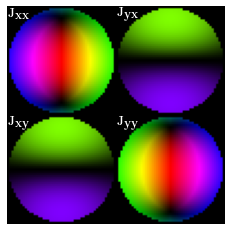

In [7]:
plot_jones(seo.get_pupil_array())
plt.savefig(os.path.join(fig_folder, fig_sub_folder,'jones_seo.pdf'), bbox_inches='tight')

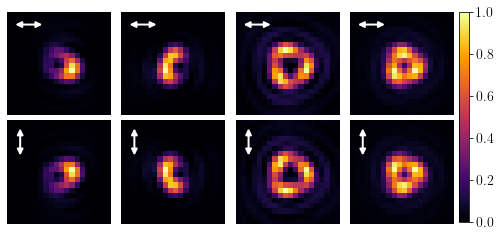

In [8]:
stack_xyz = get_xyzstack([src, seo], pol_seo)
plot_xyz(stack_xyz)
plt.savefig(os.path.join(fig_folder, fig_sub_folder,'seo_stackxyz.pdf'), bbox_inches='tight')

### 2.1 With polarization diversity

In [9]:
psfs = PSFStack([src, defocus, seo], zdiversity=zdiv, pdiversity=pdiv, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0])

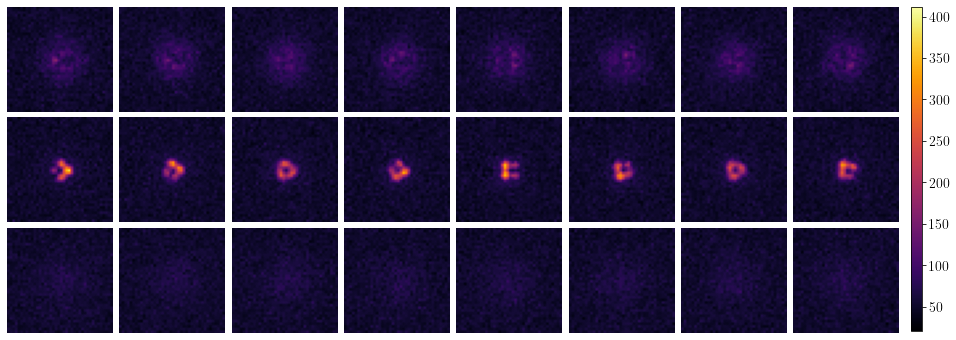

In [10]:
data_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=10000,N_pts=40,noise=True)
plot_zpstack(data_stack, N_p=8)
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'stack.pdf'), bbox_inches='tight')

c:\Users\Rodrigo.SAOPAULO\anaconda3\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 200/200 [00:19<00:00, 10.20it/s]


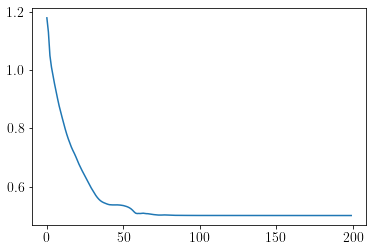

In [11]:
model, loss_evol = find_pupil(data_stack, params_ret, lr=3e-2, n_epochs=200, 
    loss_fn=loss_loglikelihood)
plt.plot(loss_evol)
# plt.gca().set_yscale('log')

0.045594642538303344 tensor(0.0190)
-0.011770888019086429 tensor(-0.0479)


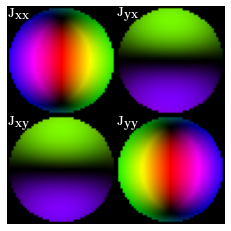

In [12]:
ret_pupil_params = get_pupils_param_dict(model)
delta_gt, zf_gt = get_dNzf(psfs)
delta_ret = model.pupils[0].delta
zf_ret = model.pupils[0].alpha * delta_ret + ret_pupil_params['pupil1']['delta_z']
print(delta_gt,delta_ret)
print(zf_gt,zf_ret)
abe = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil2'])
plot_jones(abe.get_pupil_array())
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'jones_seo_retzp.pdf'), bbox_inches='tight')

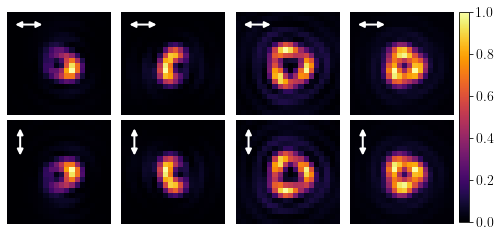

In [13]:
stack_xyz = get_xyzstack([src, abe], pol_seo)
plot_xyz(stack_xyz)
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'seo_stackxyz_retzp.pdf'), bbox_inches='tight')

### 2.2 Without polarization diversity

In [14]:
psfs = PSFStack([src, defocus, seo], zdiversity=zdiv, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0])

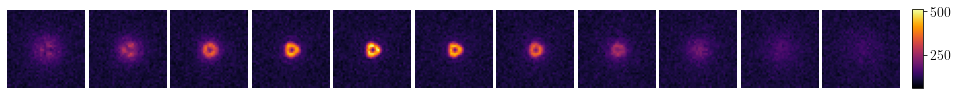

In [15]:
data_stack = psfs.model_experimental_stack(bckgd_photons=100,N_photons=20000,N_pts=40,noise=True)
plot_zstack(data_stack, N_z=11)

100%|██████████| 200/200 [00:13<00:00, 14.39it/s]


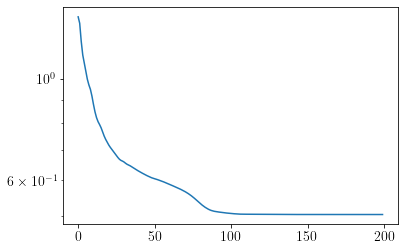

In [16]:
model, loss_evol = find_pupil(data_stack, params_ret, lr=3e-2, n_epochs=200, loss_fn=loss_loglikelihood, pdiv=False)
plt.plot(loss_evol)
plt.gca().set_yscale('log')

0.045594642538303344 tensor(0.0190)
-0.011770888019086429 tensor(-0.0467)


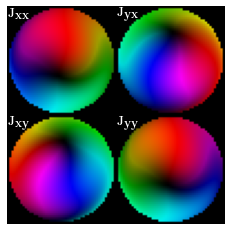

In [17]:
ret_pupil_params = get_pupils_param_dict(model)
delta_gt, zf_gt = get_dNzf(psfs)
delta_ret = model.pupils[0].delta
zf_ret = model.pupils[0].alpha * delta_ret + ret_pupil_params['pupil1']['delta_z']
print(delta_gt,delta_ret)
print(zf_gt,zf_ret)
abe = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil2'])
plot_jones(abe.get_pupil_array())
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'jones_seo_retz.pdf'), bbox_inches='tight')

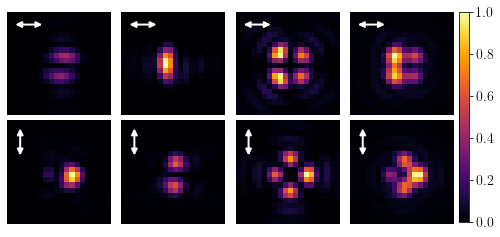

In [18]:
stack_xyz = get_xyzstack([src, abe], pol_seo)
plot_xyz(stack_xyz)
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'seo_stackxyz_retz.pdf'), bbox_inches='tight')

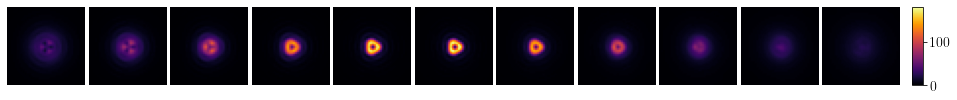

In [36]:
psfs_ret = PSFStack([src, defocus, abe], zdiversity=zdiv, blurring=blurring)
psfs_ret.compute_psf_stack(orientation=[0,0,0])
ret_stack = psfs_ret.model_experimental_stack(bckgd_photons=0,N_photons=10000,N_pts=40,noise=False)
plot_zstack(ret_stack, N_z=11)

## 3. Qplate

In [19]:
fig_sub_folder = 'qp_ret'

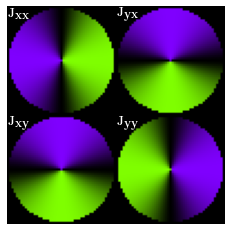

In [20]:
plot_jones(qplate.get_pupil_array())
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'jones_qp.pdf'), bbox_inches='tight')

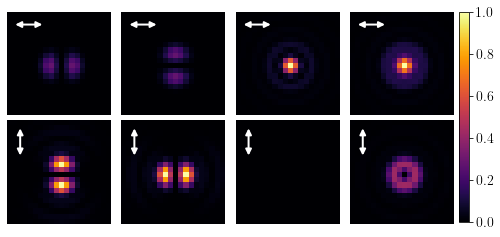

In [21]:
stack_xyz = get_xyzstack([src, qplate], wollaston)
plot_xyz(stack_xyz)
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'qp_stackxyz.pdf'), bbox_inches='tight')

### 3.1 With polarization diversity

In [22]:
psfs = PSFStack([src, defocus, qplate], zdiversity=zdiv, pdiversity=pdiv, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0])

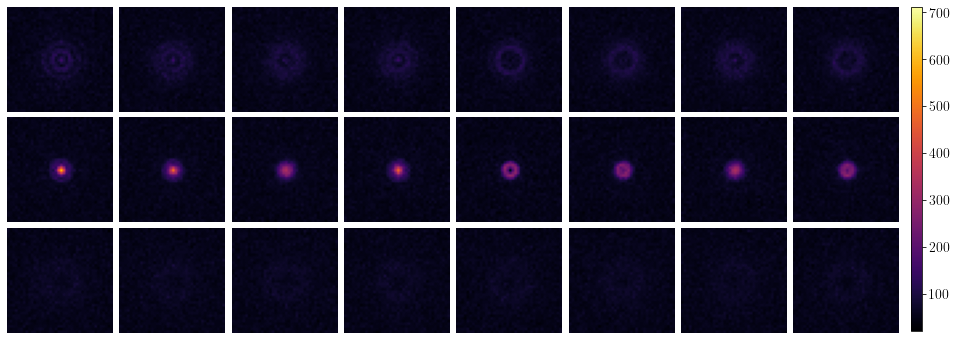

In [23]:
data_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=10000,N_pts=40,noise=True)
plot_zpstack(data_stack, N_p=8)

100%|██████████| 200/200 [00:19<00:00, 10.09it/s]


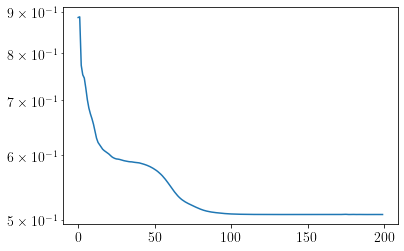

In [24]:
model, loss_evol = find_pupil(data_stack, params_ret, lr=3e-2, n_epochs=200, loss_fn=loss_loglikelihood)
plt.plot(loss_evol)
plt.gca().set_yscale('log')

0.045594642538303344 tensor(0.0190)
-0.011770888019086429 tensor(-0.0464)


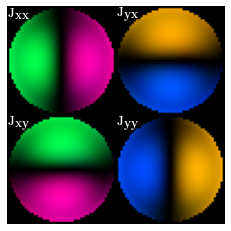

In [25]:
ret_pupil_params = get_pupils_param_dict(model)
delta_gt, zf_gt = get_dNzf(psfs)
delta_ret = model.pupils[0].delta
zf_ret = model.pupils[0].alpha * delta_ret + ret_pupil_params['pupil1']['delta_z']
print(delta_gt,delta_ret)
print(zf_gt,zf_ret)
abe = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil2'])
plot_jones(abe.get_pupil_array())
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'jones_qp_retzp.pdf'), bbox_inches='tight')

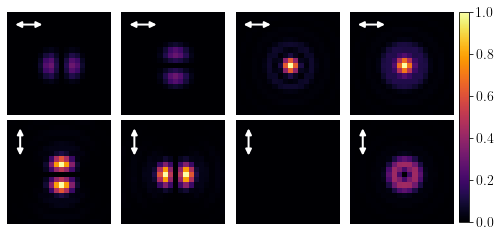

In [26]:
stack_xyz = get_xyzstack([src, abe], wollaston)
plot_xyz(stack_xyz)
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'qp_stackxyz_retzp.pdf'), bbox_inches='tight')

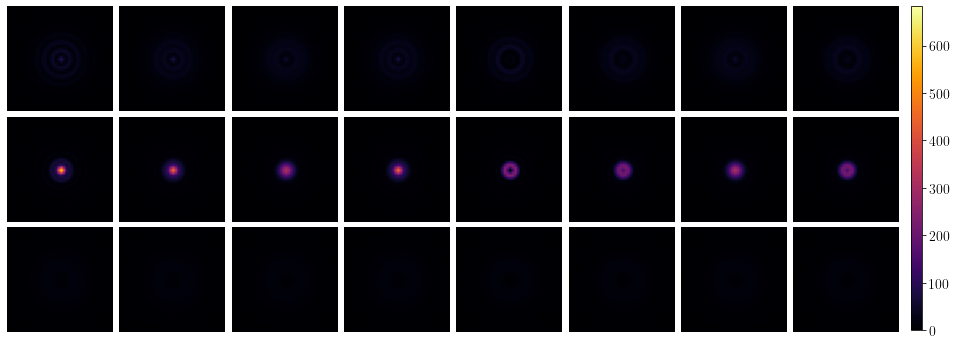

In [47]:
psfs_ret = PSFStack([src, defocus, abe], zdiversity=zdiv, pdiversity=pdiv)
psfs_ret.compute_psf_stack(orientation=[0,0,0])
ret_stack = psfs_ret.model_experimental_stack(bckgd_photons=0,N_photons=10000,N_pts=40,noise=False)
plot_zpstack(ret_stack, N_p=8)

### 3.2 Without polarization diversity

In [27]:
psfs = PSFStack([src, defocus, qplate], zdiversity=zdiv, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0])

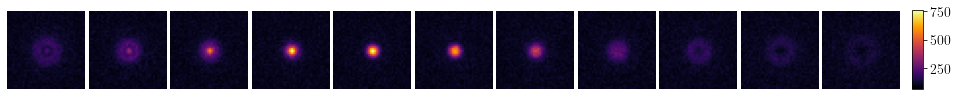

In [28]:
data_stack = psfs.model_experimental_stack(bckgd_photons=100,N_photons=20000,N_pts=40,noise=True)
plot_zstack(data_stack, N_z=11)

100%|██████████| 200/200 [00:13<00:00, 15.16it/s]


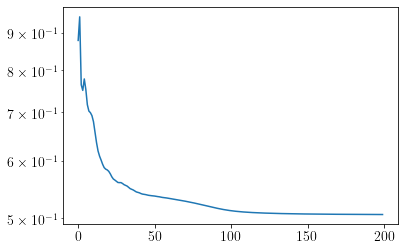

In [29]:
model, loss_evol = find_pupil(data_stack, params_ret, lr=3e-2, n_epochs=200, loss_fn=loss_loglikelihood, pdiv=False)
plt.plot(loss_evol)
plt.gca().set_yscale('log')

0.045594642538303344 tensor(0.0190)
-0.011770888019086429 tensor(-0.0480)


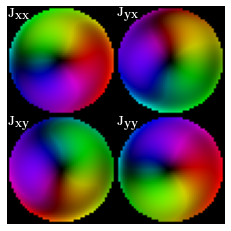

In [30]:
ret_pupil_params = get_pupils_param_dict(model)
delta_gt, zf_gt = get_dNzf(psfs)
delta_ret = model.pupils[0].delta
zf_ret = model.pupils[0].alpha * delta_ret + ret_pupil_params['pupil1']['delta_z']
print(delta_gt,delta_ret)
print(zf_gt,zf_ret)
abe = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil2'])
plot_jones(abe.get_pupil_array())
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'jones_qp_retz.pdf'), bbox_inches='tight')

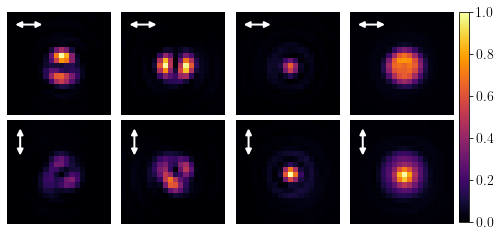

In [31]:
stack_xyz = get_xyzstack([src, abe], wollaston)
plot_xyz(stack_xyz)
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'qp_stackxyz_retz.pdf'), bbox_inches='tight')

## 4. Blurring

In [33]:
fig_sub_folder = 'blurring_fig'
radius = 150
params['source']['alpha'] = 0
params['source']['delta'] = (radius + np.random.rand()*20)/wavelength
params['defocus']['delta_z'] = (alpha*radius + (np.random.rand()-0.5)*40)/wavelength
params['blurring']['radius'] = radius/wavelength
blurring_slices = 21
params['blurring']['diff_del_list'] = np.linspace(-radius/wavelength,
    radius/wavelength,blurring_slices+2)[1:-1] 

params_ret['source']['delta'] = radius/wavelength

src = srcs.DipoleInterfaceSource(**params['pupil'],**params['source'])
defocus = wdws.Defocus(**params['pupil'],**params['defocus'])
blurring = ExactBlurring(**params['blurring'],**params['pupil'])

In [34]:
psfs = PSFStack([src, defocus, seo], zdiversity=zdiv, pdiversity=pdiv, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0], N_trim=40)

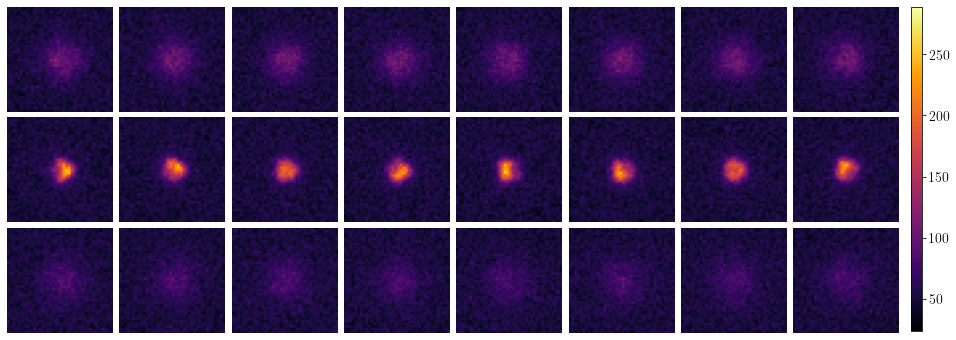

In [35]:
data_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=10000,noise=True)
plot_zpstack(data_stack, N_p=8)
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'blurred_stack.pdf'), bbox_inches='tight')

In [36]:
torch_blurr2d = torch2DBlurring(radius=radius/wavelength,**params['pupil'])
torch_blurrSA = torchSABlurring(radius=radius/wavelength,**params['pupil'])

100%|██████████| 200/200 [00:19<00:00, 10.42it/s]


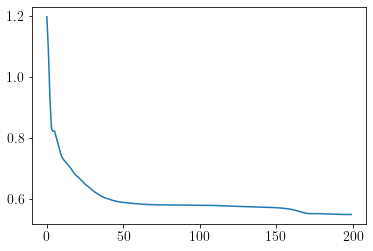

In [37]:
model_noblurr, loss_evol = find_pupil(data_stack, params_ret, lr=3e-2, n_epochs=200, loss_fn=loss_loglikelihood)
plt.plot(loss_evol)

  0%|          | 0/200 [00:00<?, ?it/s]c:\Users\Rodrigo.SAOPAULO\anaconda3\lib\site-packages\torch\autograd\__init__.py:173: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Copy.cpp:239.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 200/200 [00:43<00:00,  4.63it/s]


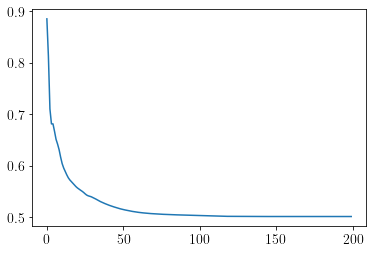

In [38]:
model_blurr2d, loss_evol = find_pupil(data_stack, params_ret, lr=3e-2, n_epochs=200, loss_fn=loss_loglikelihood, 
    blurring=torch_blurr2d)
plt.plot(loss_evol)

100%|██████████| 200/200 [02:30<00:00,  1.33it/s]


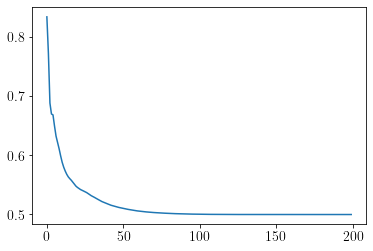

In [39]:
model_blurrSA, loss_evol = find_pupil(data_stack, params_ret, lr=3e-2, n_epochs=200, loss_fn=loss_loglikelihood, 
    blurring=torch_blurrSA)
plt.plot(loss_evol)

In [40]:
delta_gt, zf_gt = get_dNzf(psfs)

ret_pupil_params = get_pupils_param_dict(model_noblurr)
delta_noblurr = model_noblurr.pupils[0].delta
zf_noblurr = model_noblurr.pupils[0].alpha * delta_noblurr + ret_pupil_params['pupil1']['delta_z']
abe_noblurr = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil2'])

ret_pupil_params = get_pupils_param_dict(model_blurr2d)
delta_blurr2d = model_blurr2d.pupils[0].delta
zf_blurr2d = model_blurr2d.pupils[0].alpha * delta_blurr2d + ret_pupil_params['pupil1']['delta_z']
abe_blurr2d = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil2'])

ret_pupil_params = get_pupils_param_dict(model_blurrSA)
delta_blurrSA = model_blurrSA.pupils[0].delta
zf_blurrSA = model_blurrSA.pupils[0].alpha * delta_blurrSA + ret_pupil_params['pupil1']['delta_z']
abe_blurrSA = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil2'])

In [41]:
print(delta_gt,delta_noblurr,delta_blurr2d,delta_blurrSA)
print(zf_gt,zf_noblurr,zf_blurr2d,zf_blurrSA)

0.311580613398731 tensor(0.2857) tensor(0.2857) tensor(0.2857)
0.38088615653648733 tensor(0.3341) tensor(0.3522) tensor(0.3414)


In [42]:
corr = []
for bm, tag in [[abe_noblurr,'noblurr'], [abe_blurr2d,'2d'], [abe_blurrSA,'SA']]:
   corr += [cpx_corr(bm.get_pupil_array(), seo.get_pupil_array())]
np.abs(corr)

array([0.01137957, 0.97535973, 0.99844071])

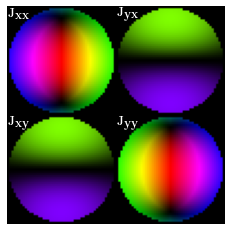

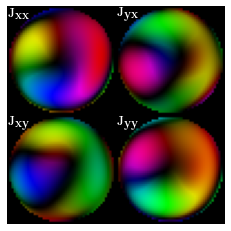

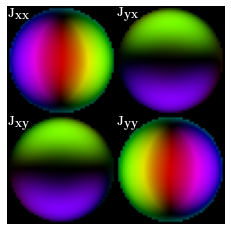

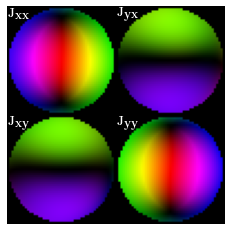

In [43]:
for bm, tag in [[seo,'gt'], [abe_noblurr,'noblurr'], [abe_blurr2d,'2d'], [abe_blurrSA,'SA']]:
    plot_jones(bm.get_pupil_array())
    plt.savefig(os.path.join(fig_folder,fig_sub_folder,'blurr_seo_'+tag+'.pdf'), bbox_inches='tight')

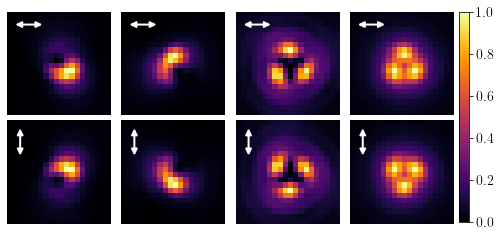

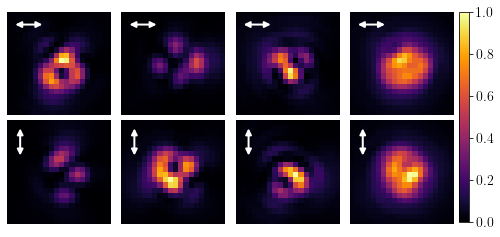

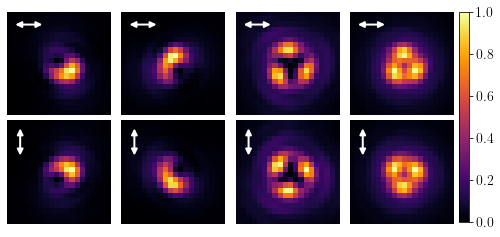

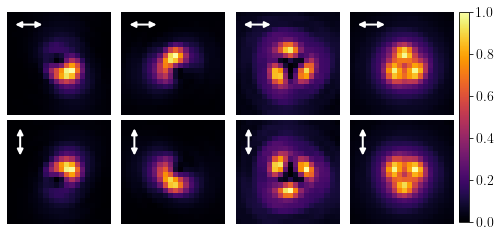

In [44]:
for bm, tag in [[seo,'gt'], [abe_noblurr,'noblurr'], [abe_blurr2d,'2d'], [abe_blurrSA,'SA']]:
    stack_xyz = get_xyzstack([src, bm], pol_seo)
    plot_xyz(stack_xyz)
    plt.savefig(os.path.join(fig_folder,fig_sub_folder,'blurr_seo_stackxyz_'+tag+'.pdf'), bbox_inches='tight')

## 5. Retrieval of scalar window

In [46]:
from pyPSFstack.pupils.aberrations import ScalarAberrations

In [60]:
c_W_tetra = np.array([0.595050119555554,
0.489068290032588,
0.452226752326030,
0.260435586819384,
0.047750334450534,
-1.039441179976503,
-0.175484816149914,
0.833009549689635,
0.154895303536154,
-0.824227959830304,
0.039942804577574,
-4.443116227167999,
0.254621433960892,
3.604115918547898,
-0.019994555526541])/(2*np.pi)

In [65]:
tetra = ScalarAberrations(c_A=[1], c_W=c_W_tetra[1:], **params['pupil'], index_convention='standard')

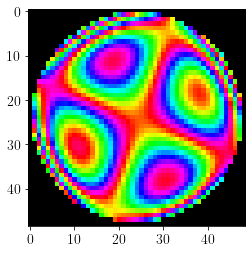

In [66]:
plt.imshow(colorize(tetra.get_pupil_array()))

## 6. Retrieval with defocus and saf

In [5]:
radius = 10
params['blurring']['radius'] = radius/wavelength
params['blurring']['diff_del_list'] = np.linspace(-radius/wavelength,
    radius/wavelength,blurring_slices+2)[1:-1] 

In [6]:
src = DipoleInterfaceSource(**params['pupil'],alpha=4.,delta=2*radius/wavelength)
blurring = ExactBlurring(**params['blurring'],**params['pupil'])

In [7]:
psfs = PSFStack([src, seo], zdiversity=zdiv, pdiversity=pdiv, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0],N_trim=40)

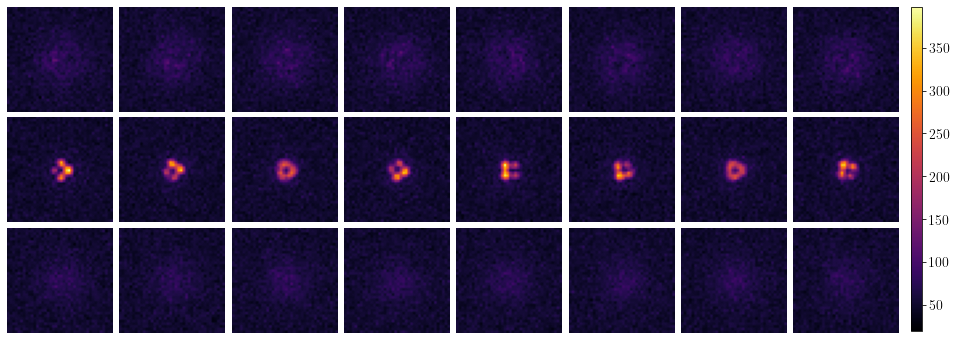

In [8]:
data_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=10000,N_pts=40,noise=True)
plot_zpstack(data_stack, N_p=8)

100%|██████████| 200/200 [00:18<00:00, 10.95it/s]


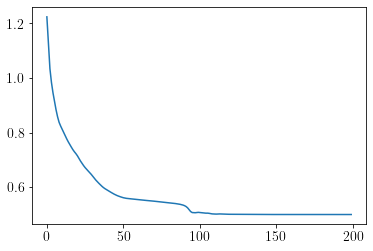

In [11]:
model, loss_evol = find_pupil(data_stack, params, lr=3e-2, n_epochs=200, loss_fn=loss_loglikelihood, opt_def=True, opt_delta=True)
plt.plot(loss_evol)

In [18]:
psfs.pupils[0].alpha

4.0

In [16]:
1*radius/wavelength

0.01904761904761905

In [17]:
model.pupils[0].alpha

1.2421092715148427

0.0380952380952381 0.057891004
0.1523809523809524 0.18033683894247604


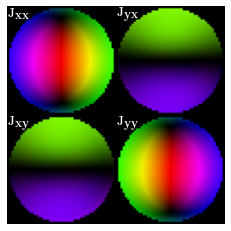

In [20]:
ret_pupil_params = get_pupils_param_dict(model)
delta_gt = psfs.pupils[0].delta
zf_gt = delta_gt * psfs.pupils[0].alpha
delta_ret = ret_pupil_params['pupil0']['delta']
zf_ret = model.pupils[0].alpha * delta_ret + ret_pupil_params['pupil1']['delta_z']
print(delta_gt,delta_ret)
print(zf_gt,zf_ret)
abe = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil2'])
plot_jones(abe.get_pupil_array())

# Extra stuff

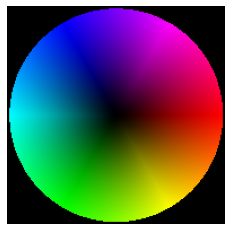

In [39]:
src2 = DipoleInterfaceSource(**params['pupil'],**params['source'])
src2.N_pts = 2**9
src2.step_f = src2.computation_size/src2.N_pts
r,phi =src2.polar_mesh()
ap = r*np.exp(1j*phi) *src2.get_aperture(dummy_ind=0)
# ap[src2.get_aperture(dummy_ind=0)==False] = np.nan 
plt.imshow(colorize(ap))
plt.gca().set_axis_off()
plt.savefig(os.path.join(fig_folder,'ampNphase_cb.pdf'), bbox_inches='tight')

In [ ]:
import scipy.io as sio
import sys
import os

In [ ]:
mat_data = sio.loadmat(os.path.join('data','Rodrigo_14Jul2021_TIRF_Run1.mat'))

In [ ]:
zdiv_mid_ind = 6
fig, axs = plt.subplots(3,3,figsize=(8,8))
for ind in range(3):
    axs[0,ind].imshow(mat_data['beads_rodrigo'][0,...,0,ind])
    axs[1,ind].imshow(mat_data['beads_rodrigo'][0,...,zdiv_mid_ind,ind])
    axs[2,ind].imshow(mat_data['beads_rodrigo'][0,...,-1,ind])
for ax in axs.ravel():
    ax.set_axis_off()

In [ ]:
exp_stack = 0.24*(mat_data['beads_rodrigo'][0]-100)

In [ ]:
get_normNbck(exp_stack)